In [3]:
#pip install mediapipe opencv-python

In [50]:
#pip install pandas

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [ ]:
#cap = cv2.VideoCapture(0)
#cap = cv2.imread("C:/Users/BVer/are_you_ok/img/pose4.jpg")

dir = "C:/Users/BVer/are_you_ok/video/assult/insidedoor_01/10-1/"
cap = cv2.VideoCapture(dir + '10-1_cam01_assault03_place07_night_spring.mp4')

# Curl counter variables
counter = 0 
stage = None

## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
            wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
            
            # Calculate angle
            angle = calculate_angle(shoulder, elbow, wrist)
            
            # Visualize angle
            cv2.putText(image, str(angle), 
                           tuple(np.multiply(elbow, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )
            
            # Curl counter logic
            if angle > 160:
                stage = "down"
            if angle < 30 and stage =='down':
                stage="up"
                counter +=1
                print(counter)
                       
        except:
            pass
        
        # Render curl counter
        # Setup status box
        cv2.rectangle(image, (0,0), (225,73), (245,117,16), -1)
        
        # Rep data
        cv2.putText(image, 'REPS', (15,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(counter), 
                    (10,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
        
        # Stage data
        cv2.putText(image, 'STAGE', (65,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, stage, 
                    (60,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
        
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )               
        
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

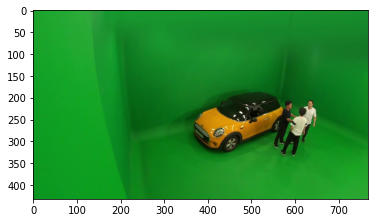

In [27]:
frame = cv2.imread("C:/Users/BVer/are_you_ok/img/pose303.jpg")
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    # Recolor image to RGB
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False

    # Make detection
    results = pose.process(image)

    # Recolor back to BGR plt로 출력할땐 주석처리
#     image.flags.writeable = True
#     image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Extract landmarks
    try:
        landmarks = results.pose_landmarks.landmark
        move_landmark(results.pose_landmarks, 0, 0)
#         print(results.pose_landmarks)
#         print(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x)
#         for lndmrk in mp_pose.PoseLandmark: #값 추출
#             print(lndmrk)
#             print(landmarks[lndmrk.value].x)
    except:
        pass


    # Render detections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
        mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
        )

    plt.imshow(image)
#         cv2.imshow('Mediapipe Feed', image)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

In [3]:
# Yolo 로드
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
classes = []
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

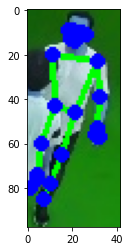

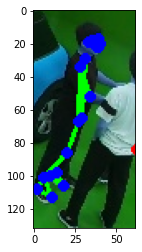

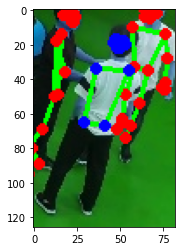

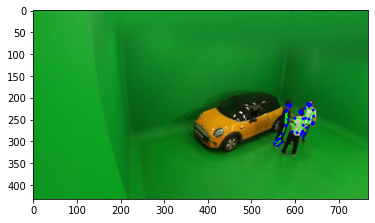

True

In [38]:
img = cv2.imread("C:/Users/BVer/are_you_ok/img/pose303.jpg")
#img = cv2.resize(img, None, fx=0.4, fy=0.4)
height, width, channels = img.shape

img.flags.writeable = True
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

blob = cv2.dnn.blobFromImage(img, 0.00392, (512, 512), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            # 좌표
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)
            
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)


new_img = img
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        if(label == 'person'):
            #frame = img[y:y+h, x:x+w]
            frame = img[y-3:y+h+6, x-3:x+w+6]
            #get_pose(frame)
            
            
            with mp_pose.Pose(model_complexity=2, min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
                # Recolor image to RGB
                smallimg = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                smallimg.flags.writeable = False
                
                # Make detection
                results = pose.process(smallimg)

                # Render detections
                mp_drawing.draw_landmarks(smallimg, results.pose_landmarks, mp_pose.POSE_CONNECTIONS) #조각별로 보기
                paint_landmark(results.pose_landmarks, x, y, w, h, width, height)
                mp_drawing.draw_landmarks(new_img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
                plt.imshow(smallimg)
                plt.show()
plt.imshow(new_img)
plt.show()

    #Recolor back to BGR plt로 출력할땐 주석처리
new_img.flags.writeable = True
new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR)

new_filename = '112'
cv2.imwrite('new_img/{0}.jpg'.format(new_filename), new_img)

In [4]:
def paint_landmark(landmarks, x, y, w, h, ori_w, ori_h):
    marks = []
    for lndmrk in mp_pose.PoseLandmark:
        try:
            if landmarks.landmark[lndmrk.value].visibility >= 0.5: #min_detection_confidence
                landmarks.landmark[lndmrk.value].x = ((x - 3) + (w + 6) * landmarks.landmark[lndmrk.value].x)/ori_w
                
                landmarks.landmark[lndmrk.value].y = ((y - 3) + (h + 6) * landmarks.landmark[lndmrk.value].y)/ori_h
                
        except:
            pass

In [14]:
video_dir = 'C:/Users/BVer/are_you_ok/video/assult/insidedoor_01/'
video_name = []
video_name = find_file(video_dir, r'*.mp4')
# print(video_name)

# for name in video_name:
#     #xml 파일 정보 확인
#     #비디오 이름별 폴더 만들기
#     for action_name in #xml속 actionname:
#         #액션 이름별 폴더 만들기 + 일반폴더도
    
#     #비디오 프레임으로 나누기
#     #프레임 이미지에서 스켈레톤 따기 (프레임 수 확인해서 엑션에 있으면 각각의 엑션 폴더에 아니면 일반 폴더에 이미지 저장, csv에 행동명과 landmark 좌표 저장)
    
 

## 파일 검색

In [13]:
import pathlib
import os

def find_file(fileDir, fileExt):
    for name in os.listdir(fileDir):
        fileDir = video_dir + name
        for name in pathlib.Path(fileDir).glob(fileExt):
            video_name.append(str(name))

## csv 쓰기

In [ ]:
#미완

def w_csv(video_name, row):
    f = open('{0}_landmark.csv'.format(video_name),'w', newline='')
    wr = csv.writer(f)
    wr.writerow(row)
    f.close()

#     f = open('landmark.csv','a', newline='')
#     wr = csv.writer(f)
#     wr.writerow([3,'최번개', '강원'])
#     f.close()

## 객체 인식

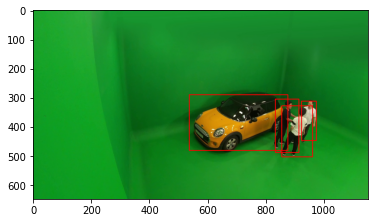

In [39]:
img = cv2.imread("C:/Users/BVer/are_you_ok/img/pose301.jpg")
#img = cv2.resize(img, None, fx=0.4, fy=0.4)
height, width, channels = img.shape

img.flags.writeable = True
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

blob = cv2.dnn.blobFromImage(img, 0.00392, (512, 512), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            # 좌표
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)
            
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
colors = []
for i in range(len(boxes)):
    colors.append(1111)
    if i in indexes:
        
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = colors[i]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
plt.imshow(img)